# Exploring the aggregate negative values in CT scans

I have been wondering about the negative values that represent 11% of the dataset, more specifically i was asking myself: where are they located within each CT scan (at the center, or at the edges?) It would make so much sense if the negative values are at the edge - this would validate that these values are filled as part of a system that represents NaNs.

Therefore in this notebook I attempt at compressing the big_array into a 2D one (along the 0 axis) and visualize it as a heatmap - I wonder if this will work.

In this notebook:

- Import of the libraries needed to rebuild the `big_array` object.
- Summing the big_array values (< -1000>) along axis 0
- Visualizing the resulting heatmap

## Importing libraries

In [13]:
from LUNA16.utils.analyze_folders import analyze_folder
from LUNA16.utils.analyze_data_distribution import read_mhd
import matplotlib.pyplot as plt
import random
import dask
import dask.array as da
import numpy as np
from dask.distributed import Client
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 8]
random.seed(123)

In [14]:
ROOT_FOLDER = "/home/azureuser/cloudfiles/data/LUNA16/extracted"
all_files = analyze_folder(ROOT_FOLDER)
assert len(all_files) == 3567
all_mhd_files = [file for file in all_files if file.extension == "mhd"]
assert len(all_mhd_files) == 1776

In [15]:
%%time
lazy_array = [dask.delayed(read_mhd)(x) for x in all_mhd_files]
lazy_array = [da.from_delayed(x, shape=(np.nan, 512, 512), dtype=np.float32) for x in lazy_array]
lazy_array = da.concatenate(lazy_array, axis=0)

CPU times: user 403 ms, sys: 14.4 ms, total: 418 ms
Wall time: 417 ms


## Experimenting with a small array

First, I will experiment my logic on a small 3D numpy array to validate the outcome I was expect, and illustrate my point:

In [16]:
simple_np_array = np.random.random((3, 5, 5))
print(simple_np_array.shape)
print(simple_np_array)

(3, 5, 5)
[[[0.54892894 0.08517368 0.0871333  0.42238426 0.74309739]
  [0.47460203 0.51465039 0.96101135 0.06858086 0.53747985]
  [0.87430867 0.02273982 0.45593076 0.53537072 0.53239277]
  [0.24481455 0.33625177 0.35388545 0.93213035 0.19222316]
  [0.25318701 0.04400387 0.4559105  0.66709567 0.50990851]]

 [[0.66097478 0.50715479 0.61422297 0.72875807 0.84480422]
  [0.76669676 0.79956198 0.51491426 0.7042322  0.00911409]
  [0.91731149 0.01095865 0.92621961 0.03471483 0.93321896]
  [0.06983678 0.27070971 0.80278376 0.61363382 0.29423251]
  [0.48483838 0.71023335 0.16911563 0.3720497  0.57531252]]

 [[0.68628609 0.79357631 0.12375813 0.5847042  0.43982765]
  [0.3209151  0.93315091 0.48655141 0.87681236 0.02175106]
  [0.72753715 0.53234626 0.75001969 0.78797011 0.95811923]
  [0.80596733 0.09092099 0.22135993 0.41757604 0.40226075]
  [0.410097   0.04595729 0.72634638 0.90701587 0.94218272]]]


The process that I want to employ is:

1. In this 3D array, first produce a boolean operate that can break the array into a set of TRUE/FALSE, for example a condition that each value is < 0.5
2. Convert all true values to 1, all False values to 0
3. Sum these values on the 1st axis (axis 0) which contains the channel information
4. Visualize this using `matplotlib`'s `imshow`

I will perform each of these 4 actions below, each in an indiviaul cell that is concluded by printing the content of the variable as it is being transformed.

To help illustrate the point, the dimensions of the 3D array are 3, 5, 5. This represents 3 "slices" of CT scans, each one being 5x5. The outcome visualization should be 5x5 that represents a projection of all CT scans on a 2D plane.

In [17]:
simple_np_array = simple_np_array < 0.5
print(simple_np_array)
print(simple_np_array.shape)

[[[False  True  True  True False]
  [ True False False  True False]
  [False  True  True False False]
  [ True  True  True False  True]
  [ True  True  True False False]]

 [[False False False False False]
  [False False False False  True]
  [False  True False  True False]
  [ True  True False False  True]
  [ True False  True  True False]]

 [[False False  True False  True]
  [ True False  True False  True]
  [False False False False False]
  [False  True  True  True  True]
  [ True  True False False False]]]
(3, 5, 5)


In [18]:
simple_np_array = simple_np_array.astype(np.uint8)
print(simple_np_array)
print(simple_np_array.shape)

[[[0 1 1 1 0]
  [1 0 0 1 0]
  [0 1 1 0 0]
  [1 1 1 0 1]
  [1 1 1 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 1]
  [0 1 0 1 0]
  [1 1 0 0 1]
  [1 0 1 1 0]]

 [[0 0 1 0 1]
  [1 0 1 0 1]
  [0 0 0 0 0]
  [0 1 1 1 1]
  [1 1 0 0 0]]]
(3, 5, 5)


In [19]:
simple_np_array = np.sum(simple_np_array, axis=0)
print(simple_np_array)
print(simple_np_array.shape)

[[0 1 2 1 1]
 [2 0 1 1 2]
 [0 2 1 1 0]
 [2 3 2 1 3]
 [3 2 2 1 0]]
(5, 5)


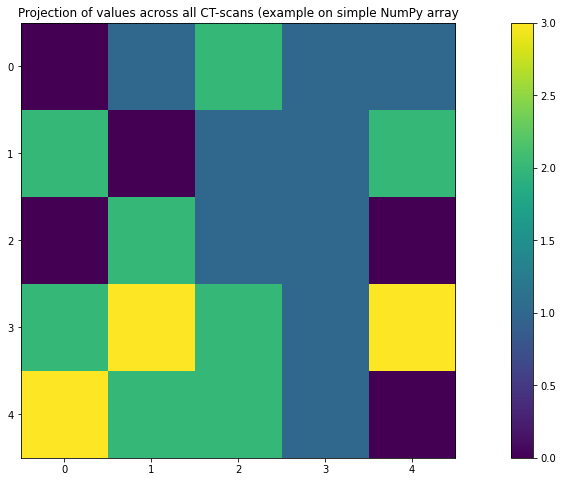

In [20]:
plt.imshow(simple_np_array)
plt.title("Projection of values across all CT-scans (example on simple NumPy array")
plt.colorbar()
plt.show()

### Implementing it on real data with dask

We will take the same process above, and try to replicate it on the complete dataset, using Dask.

In [21]:
%%time 
lazy_array = lazy_array <= -1000

CPU times: user 2.87 ms, sys: 0 ns, total: 2.87 ms
Wall time: 2.88 ms


In [22]:
%%time
lazy_array = lazy_array.astype(np.uint8) # changes values to 1/0

CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 2.22 ms


In [23]:
%%time
lazy_array = da.sum(lazy_array, axis=0)

CPU times: user 20.4 ms, sys: 181 µs, total: 20.6 ms
Wall time: 20.1 ms


In [24]:
%%time
lazy_array = lazy_array.compute()

CPU times: user 6min 54s, sys: 4min 1s, total: 10min 55s
Wall time: 4min 34s


In [25]:
print(lazy_array.shape)

(512, 512)


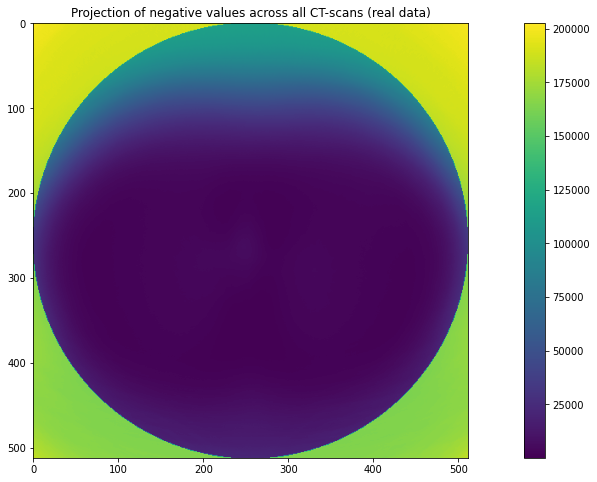

In [26]:
plt.imshow(lazy_array)
plt.title("Projection of negative values across all CT-scans (real data)")
plt.colorbar()
plt.show()

This is great outcome! we can see from the visualization above that most (if not all of the values) that are negative fall outside a circle (and I assume that this is the circle the CT-scan was scanning again, extended to become a cylinder). As a last step, I would like to clip all of these values that are outside of the CT scan, to see blind spots inside. to do so, I first need to understand about the value different between inside/outside of the scanner. I plan on using a histogram to do so:


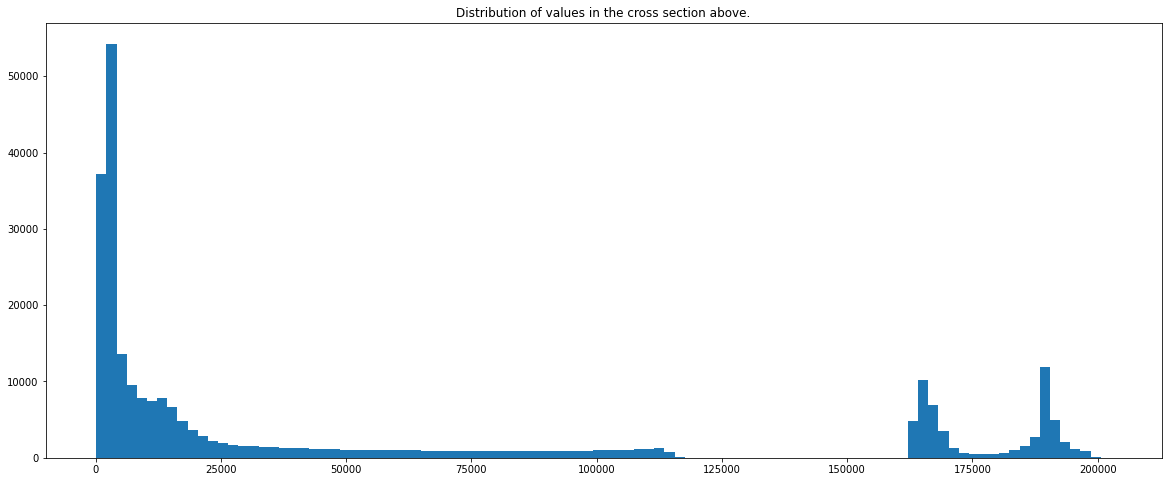

In [29]:
plt.hist(lazy_array.reshape(-1), bins=100)
plt.title("Distribution of values in the cross section above.")
plt.show()

It seems it might be worth clipping above 125000:

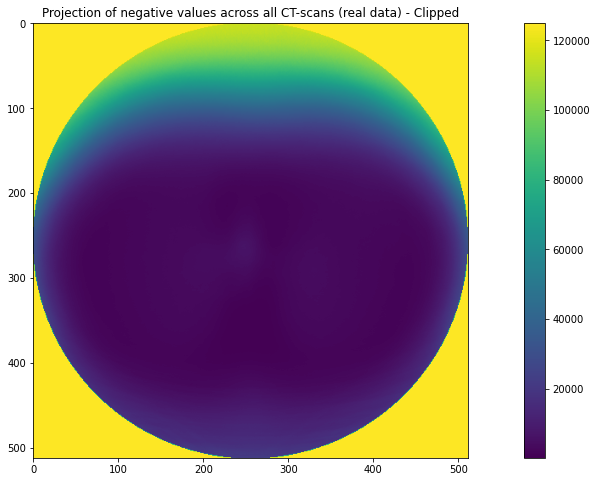

In [30]:
lazy_array_clipped = np.clip(lazy_array, 0, 125000)
plt.imshow(lazy_array_clipped)
plt.title("Projection of negative values across all CT-scans (real data) - Clipped")
plt.colorbar()
plt.show()